In [3]:
%%capture
pip install Cython

In [4]:
%%capture
pip install PyChest

In [5]:
%%capture
pip install bipartitepandas

In [6]:
%%capture
pip install pytwoway

In [7]:
%%capture
pip install ruptures

In [764]:
import simbipartiteTest as simTest
import matplotlib.pyplot as plt
import CostVisitSimTest as CostSim
import pandas as pd
import pytwoway as tw
import bipartitepandas as bpd
import numpy as np
import PyChest
import ruptures as rpt
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
# import scipy
import time
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
# Ignore warnings below
simplefilter("ignore", category=ConvergenceWarning) # Useful for logistic regression
pd.options.mode.chained_assignment = None  # default='warn' # Remove copy on slice warning

In [1024]:
def temporal_simulation(nb_of_periods,
                           n_patients,
                           n_doctors,
                           z=np.sqrt(2),
                           alpha_law_graph=(0, 0.5),
                           psi_law_graph=(0, 0.5),
                           alpha_law_cost=(0, 0.5),
                           psi_law_cost=(0, 0.5),
                           preconditioner = 'ichol',
                           beta_age_p_graph=0.01,
                           beta_age_d_graph=0.01,
                           beta_sex_p_graph=0.5,
                           beta_sex_d_graph=0.5,
                           beta_distance_graph=0.5,
                           beta_age_p_cost=0.5,
                           beta_age_d_cost=0.5,
                           beta_sex_p_cost=0.5,
                           beta_sex_d_cost=0.5,
                           beta_distance_cost=0.5):
    """
    giving some parameters, returns a dictionary containing the data generated and the estimates on the graph formation and cost models
    """
    # We set up the parameters to estimate the FE.

    if preconditioner not in ['ichol', 'jacobi']:
        raise Exception("preconditioner has to be 'ichol' or 'jacobi'. Prefer 'jacobi' for large datasets.")
        
    
    fecontrol_params = tw.fecontrol_params(
    {
        'ho': True,
        'he': False,
        'feonly': True,
        'continuous_controls': ['distance', 'age_d', 'age_p'],
        'categorical_controls': ['sex_p', 'sex_d'],
        'attach_fe_estimates': True,
        'ncore': 8,
        'preconditioner': preconditioner # It looks like jacobi gives better results (especially for large datasets ?)
    }
    )

    clean_params = bpd.clean_params(
    {
        'connectedness': 'leave_out_spell',
        'collapse_at_connectedness_measure': True,
        'drop_single_stayers': True,
        'drop_returns': 'returners',
        'copy': False
    }
    )

    rng = np.random.default_rng(None)
    alpha_graph = []
    psi_graph = []
    alpha_cost = {} # These are dicts to use the function map later
    psi_cost = {}
    changepoint_patient = np.zeros(n_patients)
    changepoint_doctor = np.zeros(n_doctors + 1)
    coor_patients = []
    coor_doctors = []
    D = np.zeros([n_patients, n_doctors + 1], dtype = np.ndarray)
    log = LogisticRegression()

    for i in range(n_patients):
        
        # We generate the FE for the graph formation model
        alpha_graph.append( np.random.uniform(alpha_law_graph[0], alpha_law_graph[1]) )
        
        # We generate the FE for the cost model
        alpha_cost[i] = np.random.uniform(alpha_law_cost[0], alpha_law_cost[1])

        # We generate the periods when there's a changepoint for each patient
        changepoint_patient[i] = np.random.randint(0, nb_of_periods)

        # Generate the coordinates of the patients
        coor_patients.append( np.random.uniform(0, 1, 2) )
                               
    for j in range(n_doctors + 1):

        # We generate the FE for the graph formation model
        psi_graph.append( np.random.uniform(psi_law_graph[0], psi_law_graph[1]) )

        # We generate the FE for the cost model
        psi_cost[j] = np.random.uniform(psi_law_cost[0], psi_law_cost[1])

        # We generate the periods when there's a changepoint for each doctor
        changepoint_doctor[j] = np.random.randint(0, nb_of_periods)
        
        if j != 0:
            
            # Generate the coordinates of the doctors
            coor_doctors.append( np.random.uniform(0, 1, 2) )

    # Generate distance matrix
    for i in range(n_patients):
        for j in range(0, n_doctors + 1):
            if j == 0: # We associate the indice 0 to the "ghost doctor"
                D[i][0] = 0
            else: # we take the j-1 index of coor_doctors as we added the ghost doctor, j = 1 corresponds to j = 0 in coord_doctors
                d = np.sqrt(np.power((coor_patients[i][0] - coor_doctors[j-1][0]), 2) + np.power((coor_patients[i][1] - coor_doctors[j-1][1]), 2))
                D[i][j] = d

    # Random draws of ages for patients and doctors
    sim_patient_age = rng.integers(low = 1, high = 99, size = n_patients)
    sim_doctor_age = rng.integers(low = 26, high = 99, size = n_doctors + 1)

    # Random draws of genders of patients and doctors
    sim_patient_gender = rng.integers(low = 0, high = 2, size = n_patients)
    sim_doctor_gender = rng.integers(low = 0, high = 2, size = n_doctors + 1)

    # Compile ids
    id_p = np.repeat(range(n_patients), n_doctors + 1)
    id_d = np.tile(range(n_doctors + 1), n_patients)

    # Compile fixed effects
    # alp_data = np.repeat(alpha_cost, n_doctors + 1)
    # psi_data = psi_graph * n_patients

    # Compile observed features
    age_p_data = np.repeat(sim_patient_age, n_doctors + 1)
    age_d_data = np.tile(sim_doctor_age, n_patients)
    sex_p_data = np.repeat(sim_patient_gender, n_doctors + 1)
    sex_d_data = np.tile(sim_doctor_gender, n_patients)

    estimates = []
                               
    # At each period, determine connections                           
    for t in range(nb_of_periods):
    
        # Generate the identifier matrix A based on the distance
        A = np.zeros([n_patients, n_doctors + 1], dtype = np.ndarray)
        for i in range(0, n_patients):
            for j in range(0, n_doctors + 1):
                if j == 0:
                    A[i][0] = 1
                elif D[i][j] > z: # if patient i and doctor j are too far away, there is no relation
                    continue
                else:
                    T = alpha_graph[i] + psi_graph[j] + beta_age_p_graph * sim_patient_age[i] + beta_age_d_graph * sim_doctor_age[j] + beta_sex_p_graph * sim_patient_gender[i] + beta_sex_d_graph * sim_doctor_gender[j] + beta_distance_graph * D[i][j]
                    p = 1 / (1 + np.exp(-T))
                    A[i][j] = np.random.binomial(1, p)

        # Compile relations between doctors and patients
        relation = A.flatten()

        # Merge all columns into a dataframe
        dataframe = pd.DataFrame(data={'i': id_p, 'j': id_d, 'y' : relation, 'age_p': age_p_data, 'age_d': age_d_data, 
                               'sex_p': sex_p_data, 'sex_d': sex_d_data
                                })
        dataframe['distance'] = D[dataframe['i'], dataframe['j']].astype(float)
        # Logistic regression for graph formation

        # Add dummy variables
        e_i = pd.DataFrame(np.zeros((n_patients*(n_doctors + 1), n_patients), dtype=int))
        for col in e_i.columns:
            e_i.rename(columns = {col :f'p_{col}'}, inplace = True)
            
        e_j = pd.DataFrame(np.zeros((n_patients*(n_doctors + 1), n_doctors + 1), dtype=int))
        for col in e_j.columns:
            e_j.rename(columns = {col :f'd_{col}'}, inplace = True)
        
        df = pd.concat([dataframe, e_i, e_j], axis = 1)
        
        for i in range(n_patients):
            indexes = df[df['i'] == i].index
            df[f'p_{i}'][indexes] = [1 for i in range(len(indexes))]
        
        for j in range(n_doctors + 1):
            indexes = df[df['j'] == j].index
            df[f'd_{j}'][indexes] = [1 for i in range(len(indexes))]
        
        y = df['y'].astype(int)
        X = df.drop(['i', 'j', 'y'], axis = 1)

        # Scale only specific columns
        # X_to_scale = X[['age_p', 'age_d']]
        # scaler = preprocessing.StandardScaler().fit(X_to_scale)
        # X_pscaled = pd.DataFrame(scaler.transform(X_to_scale))
        # X_pscaled.columns = ['age_p', 'age_d']
        # X_scaled = pd.concat([X_pscaled, X.drop(['age_p', 'age_d'], axis=1)], axis = 1)

        # Scale all columns
        # scaler = preprocessing.StandardScaler().fit(X)
        # X_scaled = scaler.transform(X)
        # reg = log.fit(X_scaled, y)
        
        reg = log.fit(X, y)
        coeffs = reg.coef_[0]

        # drop the rows if there is no relation between patient_i and doctor_j
        dataframe = dataframe.drop(dataframe[dataframe['y'] == 0].index)
        dataframe = dataframe.drop('y', axis = 1)
        dataframe = dataframe.reset_index().drop(['index'], axis = 1)

        list_of_indexes_patient = np.where(changepoint_patient == t)[0]
        list_of_indexes_doctor = np.where(changepoint_doctor == t)[0]

        # We update the laws (if needed) of the patients/doctors
        for index_patient in list_of_indexes_patient: 
            
            alpha_cost[index_patient] = np.random.uniform( np.random.uniform(alpha_law_graph[0] + 5, alpha_law_graph[1] + 5) )
    
        for index_doctor in list_of_indexes_doctor:
            
            psi_cost[index_doctor] = np.random.uniform( np.random.uniform(psi_law_graph[0] + 5, psi_law_graph[1] + 5) )

        dataframe['alpha'] = dataframe['i'].map(alpha_cost).astype(float)
        dataframe['psi'] = dataframe['j'].map(psi_cost).astype(float)
        # dataframe['distance'] = D[dataframe['i'], dataframe['j']].astype(float)

        # Compute the cost
        dataframe['y'] = dataframe['alpha'] + dataframe['psi'] + beta_age_p_cost * dataframe['age_p'] + beta_age_d_cost * dataframe['age_d'] + beta_sex_p_cost * dataframe['sex_p'] + beta_sex_d_cost * dataframe['sex_d'] + beta_distance_cost * dataframe['distance']

        # Change dtype of categorical variables
        dataframe['sex_p'] = dataframe['sex_p'].astype("category")
        dataframe['sex_d'] = dataframe['sex_d'].astype("category")

        if len(dataframe[dataframe['j'] == 0]) == 0: # s'il n'y a pas de docteur fantôme présent dans la simulation, on réindexe les docteurs (pour que leur index commence à 0)
        
            dataframe['j'] = dataframe['j'] - 1
        
        # We create a BipartiteDataFrame in order to estimate the FE
    
        bdf = bpd.BipartiteDataFrame(dataframe.drop(['alpha', 'psi'] , axis = 1),
                                     custom_categorical_dict = {'sex_p': True,
                                                                'sex_d': True},
                                     custom_dtype_dict = {'sex_p': 'categorical',
                                                          'sex_d': 'categorical'},
                                     custom_how_collapse_dict = {'sex_p': 'first',
                                                                 'sex_d': 'first'}) # We transform the dataframe as BipartitePandas dataframe to Estimate the FE.

    
        bdf.clean(clean_params)
        fe_estimator = tw.FEControlEstimator(bdf, fecontrol_params)
        print(f"Estimating FE for period {t}")
        fe_estimator.fit()
        d = {}
        d['estimates'] = fe_estimator.gamma_hat_dict # Estimates of the EF, Beta for the cost model
        # d['estimates'] = [fe_estimator.alpha_hat, fe_estimator.psi_hat]
        d['true_value'] = dataframe # True values of the features, the initial dataframe.
        d['graph'] = {}
        d['graph']['coeffs'] = coeffs
        d['graph']['alpha'] = alpha_graph
        d['graph']['psi'] = psi_graph
        estimates.append(d)

    return estimates

def extract(temporal_simulation):
    """
    temporal_simulation[t]['true_value'] is a DataFrame of data at time t
    temporal_simulation[t]['estimates'] is a dict containing the estimates from FEControlEstimator (pytwoway module) of FE at time t
    """

    
    estimates = {}
    estimates['estimates'] = {}
    estimates['estimates']['alpha'] = {}
    estimates['estimates']['psi'] = {}
    estimates['true_value'] = {}
    estimates['true_value']['alpha'] = {}
    estimates['true_value']['psi'] = {}
    
    nb_of_periods = len(temporal_simulation)
    n_patients = len(temporal_simulation[0]['estimates']['alpha'])
    n_doctors = len(temporal_simulation[0]['estimates']['psi']) # contient le docteur fantôme car on ne le supprime pas

    for i in range(n_patients):

        estimates['estimates']['alpha'][i] = []
        estimates['true_value']['alpha'][i] = []
        
    for j in range(n_doctors - 1):
            
        estimates['estimates']['psi'][j] = []
        estimates['true_value']['psi'][j] = []
    

    for t in range(nb_of_periods):
        df = temporal_simulation[t]['true_value']
        for i in temporal_simulation[t]['true_value']['i'].unique():

            estimates['estimates']['alpha'][i].append( temporal_simulation[t]['estimates']['alpha'][i] )
            estimates['true_value']['alpha'][i].append( df[df['i'] == i]['alpha'].iloc[0] )


        # for j in np.delete(simulation[t]['true_value']['j'].unique(), np.where(simulation[t]['true_value']['j'].unique() == 0)) :
        for j in range(n_doctors - 1):
    
            estimates['estimates']['psi'][j].append( temporal_simulation[t]['estimates']['psi'][j+1] )
            estimates['true_value']['psi'][j].append( df[df['j'] == j+1]['psi'].iloc[0] )

            
    return estimates

def changepoint(estimates, process_count, cost="l2"):
    """
    All the models are: "l1", "rbf", "linear", "normal", "ar"
    """
    n_patients = len(estimates['estimates']['alpha'])
    n_doctors = len(estimates['estimates']['psi'])
    changepoint_estimates = {}
    changepoint_estimates['estimates'] = {}
    changepoint_estimates['estimates']['alpha'] = {}
    changepoint_estimates['estimates']['psi'] = {}
    changepoint_estimates['true_value'] = {}
    changepoint_estimates['true_value']['alpha'] = {}
    changepoint_estimates['true_value']['psi'] = {}

    # Two best models
    # algo = rpt.Dynp(model=cost) # "l1", "l2", "rbf", "linear", "normal", "ar" 
    algo = rpt.Window(width=20, model=cost)

    # Two worst models
    # algo = rpt.Binseg(model=cost)
    # algo = rpt.BottomUp(model=cost)
    
    for i in range(n_patients):

        patient_true_signal = np.array(estimates['true_value']['alpha'][i])
        patient_estimates_signal = np.array(estimates['estimates']['alpha'][i])

        
        changepoint_estimates['true_value']['alpha'][i] = algo.fit_predict(patient_true_signal, n_bkps=process_count - 1)[0]
        changepoint_estimates['estimates']['alpha'][i] = algo.fit_predict(patient_estimates_signal, n_bkps=process_count - 1)[0]

        
    for j in range(n_doctors):

        doctor_true_signal = np.array(estimates['true_value']['psi'][j])
        doctor_estimates_signal = np.array(estimates['estimates']['psi'][j]) 
        
        changepoint_estimates['true_value']['psi'][j] = algo.fit_predict(doctor_true_signal, n_bkps=process_count - 1)[0]
        changepoint_estimates['estimates']['psi'][j] = algo.fit_predict(doctor_estimates_signal, n_bkps=process_count - 1)[0]

    
    return changepoint_estimates

def changepoint_accuracy(changepoint_estimates):

    accuracy = {}
    n_patients = len(chngpts['estimates']['alpha'])
    n_doctors = len(chngpts['estimates']['psi'])
    patient_true_estimation = 0
    doctor_true_estimation = 0
    
    for i in range(n_patients):
        
        if changepoint_estimates['estimates']['alpha'][i] == changepoint_estimates['true_value']['alpha'][i]:
            patient_true_estimation += 1
            
    for j in range(n_doctors):

        if changepoint_estimates['estimates']['psi'][j] == changepoint_estimates['true_value']['psi'][j]:
            doctor_true_estimation += 1

    accuracy['patient'] = patient_true_estimation / n_patients
    accuracy['doctor'] = doctor_true_estimation / n_doctors

    return accuracy


def rmse(simulation,
         beta_agep_graph=0.01,
         beta_aged_graph=0.01,
         beta_sexp_graph=0.5,
         beta_sexd_graph=0.5,
         beta_dist_graph=-0.5,
         beta_agep_cost=0.01,
         beta_aged_cost=0.01,
         beta_sexp_cost=0.5,
         beta_sexd_cost=0.5,
         beta_dist_cost=0.5,
        ):
    """
    returns the mean of RMSE of a simulation for patients and doctors
    """
    results = {}
    results['graph'] = {}
    results['graph']['patients'] = []
    results['graph']['doctors'] = []
    results['graph']['beta'] = {}
    results['graph']['beta']['age_p'] = []
    results['graph']['beta']['age_d'] = []
    results['graph']['beta']['sex_p'] = []
    results['graph']['beta']['sex_d'] = []
    results['graph']['beta']['distance'] = []
    results['cost'] = {}
    results['cost']['patients'] = []
    results['cost']['doctors'] = []
    results['cost']['beta'] = {}
    results['cost']['beta']['age_p'] = []
    results['cost']['beta']['age_d'] = []
    results['cost']['beta']['sex_p'] = []
    results['cost']['beta']['sex_d'] = []
    results['cost']['beta']['distance'] = []

    nb_of_periods = len(simulation)
    nb_patients = len(simulation[0]['estimates']['alpha'])
    nb_doctors = len(simulation[0]['estimates']['psi']) # It counts the ghost doctor

    # order_features = "age_p", "age_d", "sex_p", "sex_d", "distance"
    # simulation[t]['estimates']['distance']
    for t in range(nb_of_periods):
        
        s_patients = 0
        s_doctors = 0
        df = simulation[t]['true_value']

        # Compute RMSE for patients at time t
        for p in range(nb_patients):
            
            s_patients += (simulation[t]['estimates']['alpha'][p] - df[df['i'] == p]['alpha'].iloc[0]) ** 2

        # Compute RMSE for doctors at time t
        for d in range(nb_doctors - 1):

            s_doctors += (simulation[t]['estimates']['psi'][d+1] - df[df['j'] == d+1]['psi'].iloc[0]) ** 2

        # Compute RMSE for the betas of the graph formation model
        results['graph']['beta']['age_p'].append( np.sqrt( (simulation[t]['graph']['coeffs'][0] - beta_agep_graph ) ** 2 ) )
        results['graph']['beta']['age_d'].append( np.sqrt( (simulation[t]['graph']['coeffs'][1] - beta_aged_graph ) ** 2 ) )
        results['graph']['beta']['sex_p'].append( np.sqrt( (simulation[t]['graph']['coeffs'][2] - beta_sexp_graph ) ** 2 ) )
        results['graph']['beta']['sex_d'].append( np.sqrt( (simulation[t]['graph']['coeffs'][3] - beta_sexd_graph ) ** 2 ) )
        results['graph']['beta']['distance'].append( np.sqrt( (simulation[t]['graph']['coeffs'][4] - beta_dist_graph ) ** 2 ) )

        #Compute RMSE for the betas of the cost model
        results['cost']['beta']['age_p'].append( np.sqrt( (simulation[t]['estimates']['age_p'] - beta_agep_cost ) ** 2 ) )
        results['cost']['beta']['age_d'].append( np.sqrt( (simulation[t]['estimates']['age_d'] - beta_aged_cost ) ** 2 ) )
        results['cost']['beta']['sex_p'].append( np.sqrt( (simulation[t]['estimates']['sex_p'] - beta_sexp_cost ) ** 2 ) )
        results['cost']['beta']['sex_d'].append( np.sqrt( (simulation[t]['estimates']['sex_d'] - beta_sexd_cost ) ** 2 ) )
        results['cost']['beta']['distance'].append( np.sqrt( (simulation[t]['estimates']['distance'] - beta_dist_cost ) ** 2 ) )

        # Append RMSE of the FE of the graph/cost models    
        results['cost']['patients'].append(np.sqrt(s_patients / nb_patients))
        results['cost']['doctors'].append(np.sqrt(s_doctors / nb_doctors))
        results['graph']['patients'].append ( mean_squared_error(simulation[t]['graph']['alpha'], simulation[t]['graph']['coeffs'][5: 5 + nb_patients], squared=True) )
        results['graph']['doctors'].append ( mean_squared_error(simulation[t]['graph']['psi'][1:], simulation[t]['graph']['coeffs'][5 + nb_patients + 1:], squared=True) ) #We "dodge" the ghost doctor

    mean_rmse_graph_age_p = np.array( results['graph']['beta']['age_p'] ).mean()
    mean_rmse_graph_age_d = np.array( results['graph']['beta']['age_d'] ).mean()
    mean_rmse_graph_sex_p = np.array( results['graph']['beta']['sex_p'] ).mean()
    mean_rmse_graph_sex_d = np.array( results['graph']['beta']['sex_d'] ).mean()
    mean_rmse_graph_distance = np.array( results['graph']['beta']['distance'] ).mean()
    mean_rmse_cost_age_p = np.array( results['cost']['beta']['age_p'] ).mean()
    mean_rmse_cost_age_d = np.array( results['cost']['beta']['age_d'] ).mean()
    mean_rmse_cost_sex_p = np.array( results['cost']['beta']['sex_p'] ).mean()
    mean_rmse_cost_sex_d = np.array( results['cost']['beta']['sex_d'] ).mean()
    mean_rmse_cost_distance = np.array( results['cost']['beta']['distance'] ).mean()

    # For each period t, we have computed the RMSE. So we take the mean of the RMSE based on all periods.
    # FE
    mean_rmse_cost_patients = np.array(results['cost']['patients']).mean()
    mean_rmse_cost_doctors = np.array(results['cost']['doctors']).mean()
    mean_rmse_graph_patients = np.array(results['graph']['patients']).mean()
    mean_rmse_graph_doctors = np.array(results['graph']['doctors']).mean()

    # Betas
    mean_rmse_graph_age_p = np.array( results['graph']['beta']['age_p'] ).mean()
    mean_rmse_graph_age_d = np.array( results['graph']['beta']['age_d'] ).mean()
    mean_rmse_graph_sex_p = np.array( results['graph']['beta']['sex_p'] ).mean()
    mean_rmse_graph_sex_d = np.array( results['graph']['beta']['sex_d'] ).mean()
    mean_rmse_graph_distance = np.array( results['graph']['beta']['distance'] ).mean()
    mean_rmse_cost_age_p = np.array( results['cost']['beta']['age_p'] ).mean()
    mean_rmse_cost_age_d = np.array( results['cost']['beta']['age_d'] ).mean()
    mean_rmse_cost_sex_p = np.array( results['cost']['beta']['sex_p'] ).mean()
    mean_rmse_cost_sex_d = np.array( results['cost']['beta']['sex_d'] ).mean()
    mean_rmse_cost_distance = np.array( results['cost']['beta']['distance'] ).mean()


    # For more clarity, we finally return a dictionary.
    d = {}
    d['cost_patients'] = mean_rmse_cost_patients
    d['cost_doctors'] = mean_rmse_cost_doctors
    d['graph_patients'] = mean_rmse_graph_patients
    d['graph_doctors'] = mean_rmse_graph_doctors
    d['graph_age_p'] = mean_rmse_graph_age_p
    d['graph_age_d'] = mean_rmse_graph_age_d
    d['graph_sex_p'] = mean_rmse_graph_sex_p
    d['graph_sex_d'] = mean_rmse_graph_sex_d
    d['graph_distance'] = mean_rmse_graph_distance
    d['cost_age_p'] = mean_rmse_cost_age_p
    d['cost_age_d'] = mean_rmse_cost_age_d
    d['cost_sex_p'] = mean_rmse_cost_sex_p
    d['cost_sex_d'] = mean_rmse_cost_sex_d
    d['cost_distance'] = mean_rmse_cost_distance
            
    return d


def aggreg_rmse(nb_of_simulations,
                nb_periods=200,
                nb_patients=200,
                nb_doctors=200,
                dist=np.sqrt(2),
                beta_agep_graph=0.01,
                beta_aged_graph=0.01,
                beta_sexp_graph=0.5,
                beta_sexd_graph=0.5,
                beta_dist_graph=-0.5,
                beta_agep_cost=0.01,
                beta_aged_cost=0.01,
                beta_sexp_cost=0.5,
                beta_sexd_cost=0.5,
                beta_dist_cost=0.5,
               ):
    
    
    rmse_cost_patients = []
    rmse_cost_doctors = []
    rmse_graph_patients = []
    rmse_graph_doctors = []
    rmse_graph_age_p = []
    rmse_graph_age_d = []
    rmse_graph_sex_p = []
    rmse_graph_sex_d = []
    rmse_graph_distance = []
    rmse_cost_age_p = []
    rmse_cost_age_d = []
    rmse_cost_sex_p = []
    rmse_cost_sex_d = []
    rmse_cost_distance = []
    
    for n in range(nb_of_simulations):

        simulation = temporal_simulation(nb_of_periods=nb_periods,
                                            n_patients=nb_patients,
                                            n_doctors=nb_doctors,
                                            z=dist,
                                            alpha_law_graph=(-1, 0),
                                            psi_law_graph=(-1, 0),
                                            alpha_law_cost=(-1, 0),
                                            psi_law_cost=(-1, 0),
                                            preconditioner = 'ichol',
                                            beta_age_p_graph=beta_agep_graph,
                                            beta_age_d_graph=beta_aged_graph,
                                            beta_sex_p_graph=beta_sexp_graph,
                                            beta_sex_d_graph=beta_sexd_graph,
                                            beta_distance_graph=beta_dist_graph,
                                            beta_age_p_cost=beta_agep_cost,
                                            beta_age_d_cost=beta_aged_cost,
                                            beta_sex_p_cost=beta_sexp_cost,
                                            beta_sex_d_cost=beta_sexd_cost,
                                            beta_distance_cost=beta_dist_cost)
        
        rm = rmse(simulation,
                 beta_agep_graph=beta_agep_graph,
                 beta_aged_graph=beta_aged_graph,
                 beta_sexp_graph=beta_sexp_graph,
                 beta_sexd_graph=beta_sexd_graph,
                 beta_dist_graph=beta_dist_graph,
                 beta_agep_cost=beta_agep_cost,
                 beta_aged_cost=beta_aged_cost,
                 beta_sexp_cost=beta_sexp_cost,
                 beta_sexd_cost=beta_sexd_cost,
                 beta_dist_cost=beta_dist_cost,
                )
        rmse_cost_patients.append( rm['cost_patients'] )
        rmse_cost_doctors.append( rm['cost_doctors'] )
        rmse_graph_patients.append ( rm['graph_patients'] )
        rmse_graph_doctors.append( rm['graph_doctors'] )
        rmse_graph_age_p.append( rm['graph_age_p'] )
        rmse_graph_age_d.append( rm['graph_age_d'] )
        rmse_graph_sex_p.append( rm['graph_sex_p'] )
        rmse_graph_sex_d.append( rm['graph_sex_d'] )
        rmse_graph_distance.append( rm['graph_distance'] )
        rmse_cost_age_p.append( rm['cost_age_p'] )
        rmse_cost_age_d.append( rm['cost_age_d'] )
        rmse_cost_sex_p.append( rm['cost_sex_p'] )
        rmse_cost_sex_d.append( rm['cost_sex_d'] )
        rmse_cost_distance.append( rm['cost_distance'] )

    d = {}
    d['cost_patients'] = rmse_cost_patients
    d['cost_doctors'] = rmse_cost_doctors
    d['graph_patients'] = rmse_graph_patients
    d['graph_doctors'] = rmse_graph_doctors
    d['graph_age_p'] = rmse_graph_age_p
    d['graph_age_d'] = rmse_graph_age_d
    d['graph_sex_p'] = rmse_graph_sex_p
    d['graph_sex_d'] = rmse_graph_sex_d
    d['graph_distance'] = rmse_graph_distance
    d['cost_age_p'] = rmse_cost_age_p
    d['cost_age_d'] = rmse_cost_age_d
    d['cost_sex_p'] = rmse_cost_sex_p
    d['cost_sex_d'] = rmse_cost_sex_d
    d['cost_distance'] = rmse_cost_distance

    # return [rmse_cost_patients, rmse_cost_doctors, rmse_graph_patients, rmse_graph_doctors]
    return d

def graph_formation(n_patients,
                    n_doctors,
                    z=1.4,
                    beta_age_p_graph=0.01,
                    beta_age_d_graph=0.01,
                    beta_sex_p_graph=0.5,
                    beta_sex_d_graph=0.5,
                    beta_distance_graph=-0.5,
                    alpha_law_graph=(-1, 0),
                    psi_law_graph=(-1, 0)
                   ):
    """
    Crée seulement la partie formation de graphe et retourne le dataframe / valeurs des EF (utile pour passer à la régression logistique et estimation des EF / Beta du graph formation seulement)
    """
    coor_patients = []
    coor_doctors = []
    alpha_graph = []
    psi_graph = []
    rng = np.random.default_rng(None)
    D = np.zeros([n_patients, n_doctors + 1], dtype = np.ndarray)

    for i in range(n_patients):
        
        # We generate the FE for the graph formation model
        alpha_graph.append( np.random.uniform(alpha_law_graph[0], alpha_law_graph[1]) )

        # Generate the coordinates of the patients
        coor_patients.append( np.random.uniform(0, 1, 2) )
                               
    for j in range(n_doctors + 1):

        # We generate the FE for the graph formation model
        psi_graph.append( np.random.uniform(psi_law_graph[0], psi_law_graph[1]) )
        
        if j != 0:
            
            # Generate the coordinates of the doctors
            coor_doctors.append( np.random.uniform(0, 1, 2) )

    # Generate distance matrix
    for i in range(n_patients):
        for j in range(0, n_doctors + 1):
            if j == 0: # We associate the indice 0 to the "ghost doctor"
                D[i][0] = 0
            else: # we take the j-1 index of coor_doctors as we added the ghost doctor, j = 1 corresponds to j = 0 in coord_doctors
                d = np.sqrt(np.power((coor_patients[i][0] - coor_doctors[j-1][0]), 2) + np.power((coor_patients[i][1] - coor_doctors[j-1][1]), 2))
                D[i][j] = d

    # Random draws of ages for patients and doctors
    sim_patient_age = rng.integers(low = 1, high = 99, size = n_patients)
    sim_doctor_age = rng.integers(low = 26, high = 99, size = n_doctors + 1)

    # Random draws of genders of patients and doctors
    sim_patient_gender = rng.integers(low = 0, high = 2, size = n_patients)
    sim_doctor_gender = rng.integers(low = 0, high = 2, size = n_doctors + 1)

    # Compile ids
    id_p = np.repeat(range(n_patients), n_doctors + 1)
    id_d = np.tile(range(n_doctors + 1), n_patients)

    # Compile fixed effects
    # alp_data = np.repeat(alpha_cost, n_doctors + 1)
    # psi_data = psi_graph * n_patients

    # Compile observed features
    age_p_data = np.repeat(sim_patient_age, n_doctors + 1)
    age_d_data = np.tile(sim_doctor_age, n_patients)
    sex_p_data = np.repeat(sim_patient_gender, n_doctors + 1)
    sex_d_data = np.tile(sim_doctor_gender, n_patients)

    estimates = []
                               
    # At each period, determine connections                           
    # for t in range(nb_of_periods):
    
    # Generate the identifier matrix A based on the distance
    A = np.zeros([n_patients, n_doctors + 1], dtype = np.ndarray)
    for i in range(0, n_patients):
        for j in range(0, n_doctors + 1):
            if j == 0:
                A[i][0] = 1
            elif D[i][j] > z: # if patient i and doctor j are too far away, there is no relation
                continue
            else:
                T = alpha_graph[i] + psi_graph[j] + beta_age_p_graph * sim_patient_age[i] + beta_age_d_graph * sim_doctor_age[j] + beta_sex_p_graph * sim_patient_gender[i] + beta_sex_d_graph * sim_doctor_gender[j] + beta_distance_graph * D[i][j]
                p = 1 / (1 + np.exp(-T))
                A[i][j] = np.random.binomial(1, p)

    # Compile relations between doctors and patients
    relation = A.flatten()

    # Merge all columns into a dataframe
    dataframe = pd.DataFrame(data={'i': id_p, 'j': id_d, 'y' : relation, 'age_p': age_p_data, 'age_d': age_d_data, 
                           'sex_p': sex_p_data, 'sex_d': sex_d_data
                            })
    dataframe['distance'] = D[dataframe['i'], dataframe['j']].astype(float)

    dataframe = dataframe.reset_index().drop(['index'], axis = 1)
    return (dataframe, alpha_graph, psi_graph)

In [986]:
start_time = time.time()
rm = rmse(simulation)
end_time = time.time()

In [987]:
(rm, end_time - start_time)

({'cost_patients': 1.4659202046021171,
  'cost_doctors': 1.097254689365403,
  'graph_patients': 0.3169464827349402,
  'graph_doctors': 0.2907271933343849,
  'graph_age_p': 0.0008258401093978094,
  'graph_age_d': 0.0029726502053433954,
  'graph_sex_p': 0.06991432593063038,
  'graph_sex_d': 0.04768286107013721,
  'graph_distance': 10.378123108834973,
  'cost_age_p': 0.019570068169748395,
  'cost_age_d': 0.02195638747234584,
  'cost_sex_p': 0.6934377937669367,
  'cost_sex_d': 0.6597252426627404,
  'cost_distance': 2.843067233119593e-09},
 47.53528356552124)

In [1027]:
%%capture
start_time = time.time()
simul = aggreg_rmse(nb_of_simulations=20,
                nb_periods=200,
                nb_patients=200,
                nb_doctors=200,
                dist=0.4,
                beta_agep_graph=0.01,
                beta_aged_graph=0.01,
                beta_sexp_graph=0.5,
                beta_sexd_graph=0.5,
                beta_dist_graph=-0.5,
                beta_agep_cost=0.01,
                beta_aged_cost=0.01,
                beta_sexp_cost=0.5,
                beta_sexd_cost=0.5,
                beta_dist_cost=0.5,
            )
end_time = time.time()

In [1028]:
end_time - start_time

28391.03091621399

{'whiskers': [<matplotlib.lines.Line2D at 0x7efb2f440eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7efb2f4413f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efb2f440c10>],
 'medians': [<matplotlib.lines.Line2D at 0x7efb2f441930>],
 'fliers': [<matplotlib.lines.Line2D at 0x7efb2f441bd0>],
 'means': []}

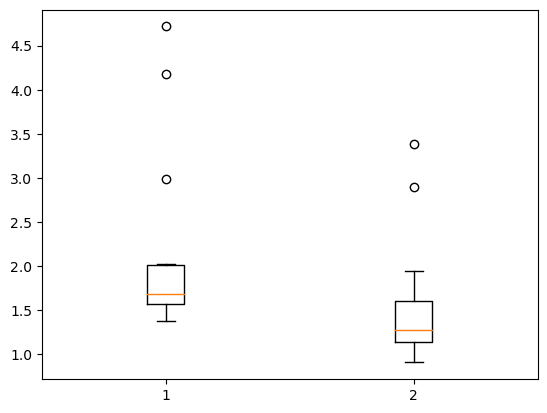

In [1039]:
plt.boxplot(simul['cost_patients'], positions = [1])
plt.boxplot(simul['cost_doctors'], positions = [2])

In [668]:
# pour les beta graph
# proba connexion proche de 0.1

beta_1 = 0.001
beta_2 = 0.001
beta_3 = 0.001
beta_4 = 0.001
beta_5 = -6

T = -0.5 + -0.5 + beta_1 * 45 + beta_2 * 60 + beta_3 * 1 + beta_4 * 1 + beta_5 * 0.5
1 / (1 + np.exp(-T))

0.019976890931318107

In [672]:
# proba connexion proche de 1
beta_1 = 0.5
beta_2 = 0.5
beta_3 = 0.5
beta_4 = 0.5
beta_5 = -0.5

T = -1 + -1 + beta_1 * 1 + beta_2 * 26 + beta_3 * 1 + beta_4 * 1 + beta_5 * 0.5
1 / (1 + np.exp(-T))

0.9999952149055051

In [997]:
pd.options.mode.chained_assignment = None  # default='warn' # Remove copy on slice warning
n_patients = 200
n_doctors = 200 # sans compter le docteur fantôme
regg = graph_formation(n_patients, n_doctors, z=0.4)

e_i = pd.DataFrame(np.zeros((n_patients*(n_doctors + 1), n_patients), dtype=int))
# e_i = pd.DataFrame(np.zeros((n_patients*(n_doctors + 1), n_patients)))
for col in e_i.columns:
    e_i.rename(columns = {col :f'p_{col}'}, inplace = True)
    
e_j = pd.DataFrame(np.zeros((n_patients*(n_doctors + 1), n_doctors + 1), dtype=int))
# e_j = pd.DataFrame(np.zeros((n_patients*(n_doctors + 1), n_doctors + 1)))
for col in e_j.columns:
    e_j.rename(columns = {col :f'd_{col}'}, inplace = True)

df = pd.concat([regg[0], e_i, e_j], axis = 1)

for i in range(n_patients):
    indexes = df[df['i'] == i].index
    df[f'p_{i}'][indexes] = [1 for i in range(len(indexes))]

for j in range(n_doctors + 1):
    indexes = df[df['j'] == j].index
    df[f'd_{j}'][indexes] = [1 for i in range(len(indexes))]

y = df['y'].astype(int)
X = df.drop(['i', 'j', 'y'], axis = 1)

# X_to_scale = X[['age_p', 'age_d']]
X_to_scale = X[['distance']]
scaler = preprocessing.StandardScaler().fit(X_to_scale)
X_pscaled = pd.DataFrame(scaler.transform(X_to_scale))
# X_pscaled.columns = ['age_p', 'age_d']
X_pscaled.columns = ['distance']
X_scaled = pd.concat([X_pscaled, X.drop(['distance'], axis=1)], axis = 1)

# scaler = preprocessing.StandardScaler().fit(X)
# X_scaled = scaler.transform(X)

log = LogisticRegression(fit_intercept=True)
reg = log.fit(X_scaled, y)

In [1000]:
reg.coef_[0][0]

-2.773940983253395

In [998]:
X_scaled

,distance,age_p,age_d,sex_p,sex_d,p_0,p_1,p_2,p_3,p_4,...,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200
0,-2.075334,36,64,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.208912,36,88,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.047890,36,54,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.976764,36,80,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.276078,36,48,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40195,0.497687,14,36,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
40196,1.658182,14,30,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
40197,1.041080,14,37,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
40198,1.460825,14,32,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


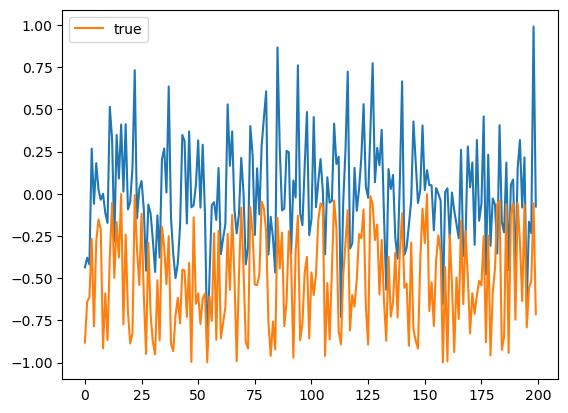

In [956]:
plt.plot(reg.coef_[0][5: 205])
plt.plot(regg[1], label='true')
plt.legend()

# plt.plot(reg.coef_[0][505:])
# plt.plot(regg[2])


In [120]:
# temporal_simulation renvoie une liste indexée par le nombre de périodes, temporal_simulation[t]['estimates'] contenant la sortie de FEControlEstimator (un dictionnaire avec les estimations) et 
# temporal_simulation[t]['true_value'] renvoie le dataframe sur lequel on estime les EF

In [919]:
%%capture
start_time = time.time()
simulation = temporal_simulation(nb_of_periods=300,
                                    n_patients=200,
                                    n_doctors=200,
                                    z=0.4,
                                    alpha_law_graph=(-1, 0),
                                    psi_law_graph=(-1, 0),
                                    alpha_law_cost=(-1, 0),
                                    psi_law_cost=(-1, 0),
                                    preconditioner = 'ichol',
                                    beta_age_p_graph=0.01,
                                    beta_age_d_graph=0.01,
                                    beta_sex_p_graph=0.5,
                                    beta_sex_d_graph=0.5,
                                    beta_distance_graph=-0.5,
                                    beta_age_p_cost=0.01,
                                    beta_age_d_cost=0.01,
                                    beta_sex_p_cost=0.5,
                                    beta_sex_d_cost=0.5,
                                    beta_distance_cost=0.5)
end_time = time.time()

In [922]:
end_time - start_time

2349.2251286506653

In [916]:
# estimates['estimates'] contient uniquement les estimations des EF
# estimates['true_value'] contient uniquement les vraies valeurs des EF
# estimates permet en particulier de ne récupérer que les EF des vrais docteurs (on ignore le docteur fantôme, et le vecteur de 0 ajouté par pytwoway)
estimates = extract(simulation)

In [649]:
# "l1", "l2", "ar", "normal"
# l2 looks the more precise
chngpts = changepoint(estimates, process_count=2, cost="l2")
changepoint_accuracy(chngpts)

{'patient': 0.77, 'doctor': 0.9047619047619048}

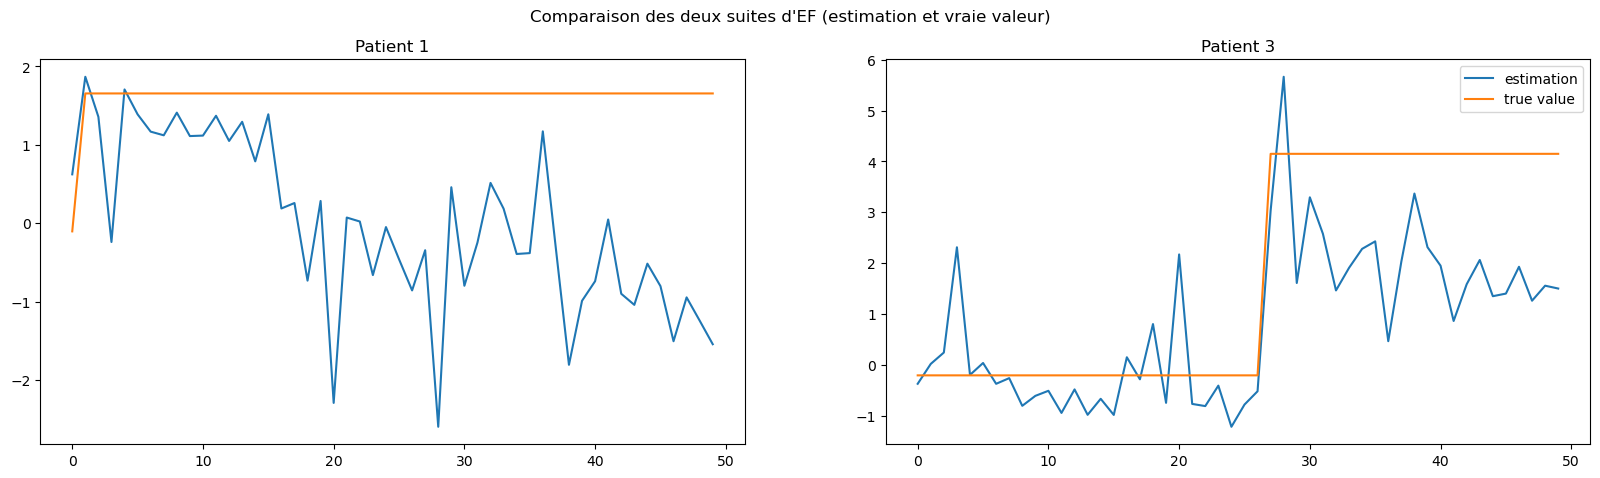

In [917]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle("Comparaison des deux suites d'EF (estimation et vraie valeur)")
ax1.plot(estimates['estimates']['alpha'][31], label = 'estimation')
ax1.plot(estimates['true_value']['alpha'][31], label = 'true value')
ax1.title.set_text('Patient 1')
ax2.plot(estimates['estimates']['alpha'][34], label = 'estimation')
ax2.plot(estimates['true_value']['alpha'][34], label = 'true value')
ax2.title.set_text('Patient 3')
plt.legend()

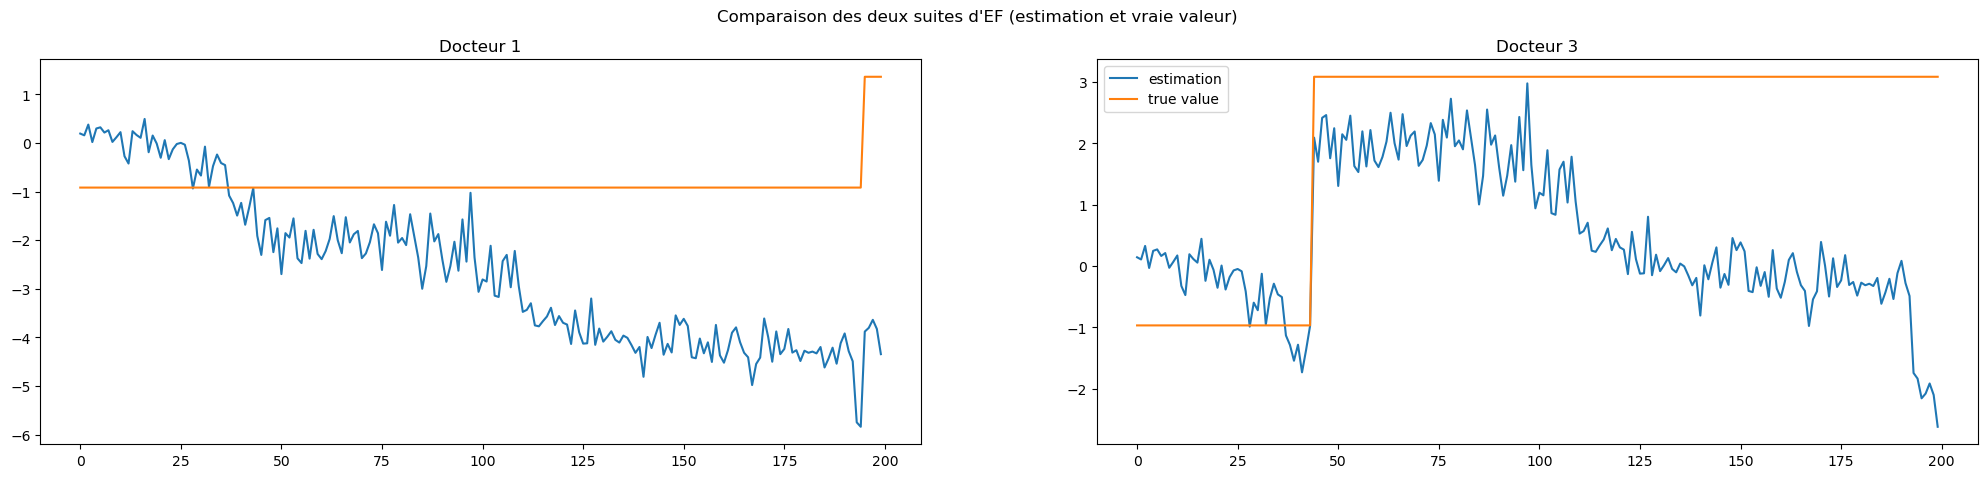

In [756]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5))
fig.suptitle("Comparaison des deux suites d'EF (estimation et vraie valeur)")
ax1.plot(estimates['estimates']['psi'][4], label = 'estimation')
ax1.plot(estimates['true_value']['psi'][4], label = 'true value')
ax1.title.set_text('Docteur 1')
ax2.plot(estimates['estimates']['psi'][5], label = 'estimation')
ax2.plot(estimates['true_value']['psi'][5], label = 'true value')
ax2.title.set_text('Docteur 3')
plt.legend()

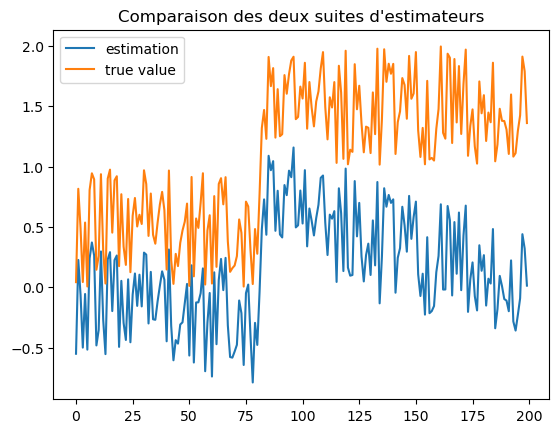

In [515]:
plt.plot(estimates['estimates']['alpha'][28], label = 'estimation')
plt.plot(estimates['true_value']['alpha'][28], label = 'true value')
plt.title("Comparaison des deux suites d'estimateurs")
plt.legend()

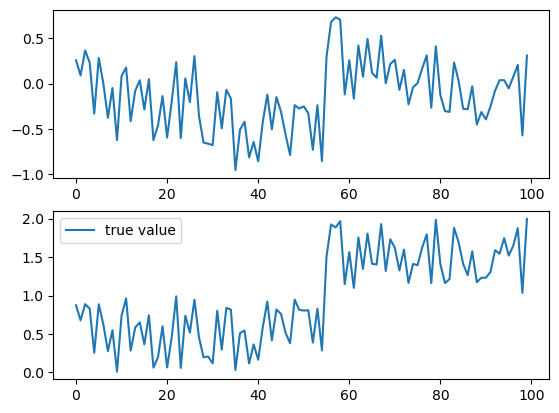

In [10]:
figure, axis = plt.subplots(2)
axis[0].plot(estimates['estimates']['alpha'][20])
axis[1].plot(estimates['true_value']['alpha'][20], label = 'true value')
plt.legend()
plt.show()

In [458]:

[[chngpts['true_value']['alpha'][i], chngpts['estimates']['alpha'][i]] for i in range(len(chngpts['estimates']['alpha']))]
# chngpts['true_value']['psi'][i], chngpts['estimates']['psi'][i]

[[20, 20],
 [95, 95],
 [175, 175],
 [145, 145],
 [145, 145],
 [110, 110],
 [170, 170],
 [180, 180],
 [45, 45],
 [165, 165],
 [145, 145],
 [105, 105],
 [35, 35],
 [60, 60],
 [180, 180],
 [155, 160],
 [165, 165],
 [10, 10],
 [110, 110],
 [50, 50],
 [75, 75],
 [25, 25],
 [150, 150],
 [35, 35],
 [120, 120],
 [70, 65],
 [70, 70],
 [80, 80],
 [40, 40],
 [185, 40],
 [120, 120],
 [35, 35],
 [45, 45],
 [55, 55],
 [10, 10],
 [70, 70],
 [40, 40],
 [185, 185],
 [10, 10],
 [60, 60],
 [145, 35],
 [125, 125],
 [75, 75],
 [150, 150],
 [55, 55],
 [40, 40],
 [15, 15],
 [140, 140],
 [30, 40],
 [30, 30],
 [10, 10],
 [115, 115],
 [170, 170],
 [10, 10],
 [180, 180],
 [25, 25],
 [175, 65],
 [25, 25],
 [10, 10],
 [130, 130],
 [180, 180],
 [35, 35],
 [80, 80],
 [65, 65],
 [90, 90],
 [115, 115],
 [115, 55],
 [20, 20],
 [130, 130],
 [135, 135],
 [180, 180],
 [185, 185],
 [120, 120],
 [35, 35],
 [30, 30],
 [185, 185],
 [170, 170],
 [60, 60],
 [100, 100],
 [185, 185],
 [180, 180],
 [120, 120],
 [30, 30],
 [125, 12

In [471]:
[[chngpts['true_value']['psi'][j], chngpts['estimates']['psi'][j]] for j in range(len(chngpts['estimates']['psi']))]

[[35, 200],
 [35, 120],
 [40, 35],
 [85, 85],
 [115, 115],
 [185, 185],
 [30, 40],
 [175, 175],
 [20, 55],
 [185, 40]]

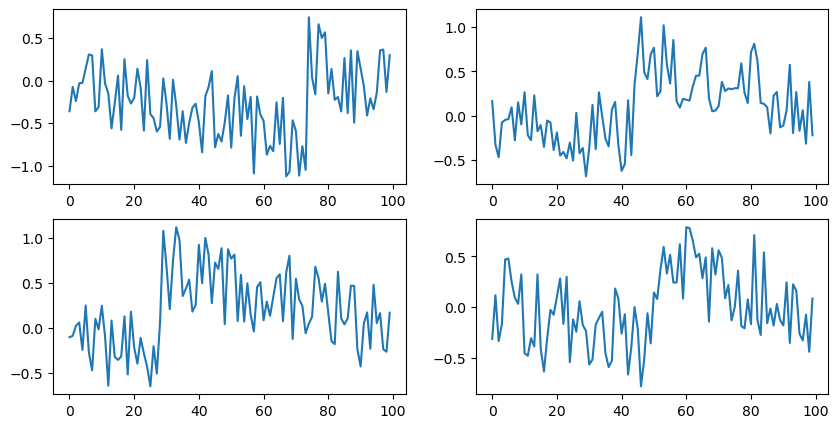

In [54]:
figure, axis = plt.subplots(2, 2, figsize=(10, 5))
axis[0, 0].plot(estimates['estimates']['alpha'][20])
axis[0, 1].plot(estimates['estimates']['alpha'][5])
axis[1, 0].plot(estimates['estimates']['alpha'][88])
axis[1, 1].plot(estimates['estimates']['alpha'][46])

In [59]:
estimates['estimates']['alpha'][10][1] - estimates['estimates']['alpha'][10][0]

0.14803293965119235

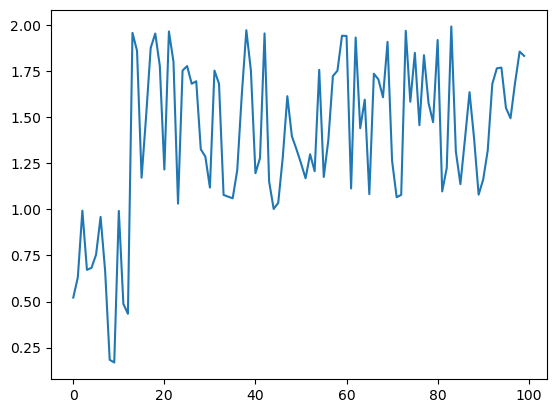

In [62]:
plt.plot(pd.DataFrame(estimates['true_value']['alpha'][10]))

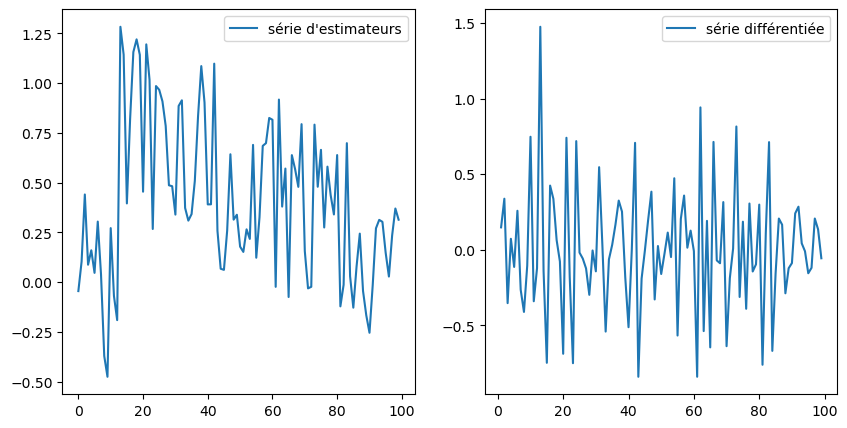

In [55]:
test = pd.DataFrame(estimates['estimates']['alpha'][10])
test2 = pd.DataFrame(estimates['true_value']['alpha'][10])
figure, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].plot(test, label = "série d'estimateurs")
axis[0].legend()
axis[1].plot(test.diff().values, label = 'série différentiée')
axis[1].legend()

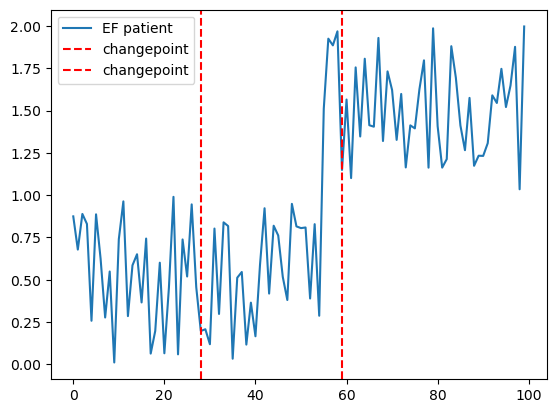

In [16]:
plt.plot(estimates['true_value']['alpha'][20], label = 'EF patient')
plt.axvline(28, color = 'red', linestyle = 'dashed', label = "changepoint")
plt.axvline(59, color = 'red', linestyle = 'dashed', label = "changepoint")
plt.legend()
plt.show()

In [ ]:
%%capture 
alpha_law = (0, 0.5)
psi_law = (0, 0.5)
model = simTest.SimBipartiteTest(
    simTest.sim_params(
    {
        'n_patients' : 150,
        'n_doctors' : 10,
        'alpha_law': alpha_law,
        'psi_law': psi_law,
        'beta_1': 0.001,
        'beta_2': 0.001,
        'beta_3': 0.01,
        'beta_4': 0.01,
        'beta_5': -0.5,
        'z': 0.2,
    }
    )
)
df = model.simulate()
distance_matrix = model.D # We need to simulate first so the matrix D is generated
simulation = temporal_simulation(df,
                                 distance_matrix,
                                 200,
                                 (0, 0.5),
                                 psi_law=(0, 0.5),
                                 # preconditioner='jacobi',
                                 beta_age_p=0.5,
                                 beta_age_d=0.5,
                                 beta_sex_p=0.5,
                                 beta_sex_d=0.5,
                                 beta_distance=0.5
                        
                          )

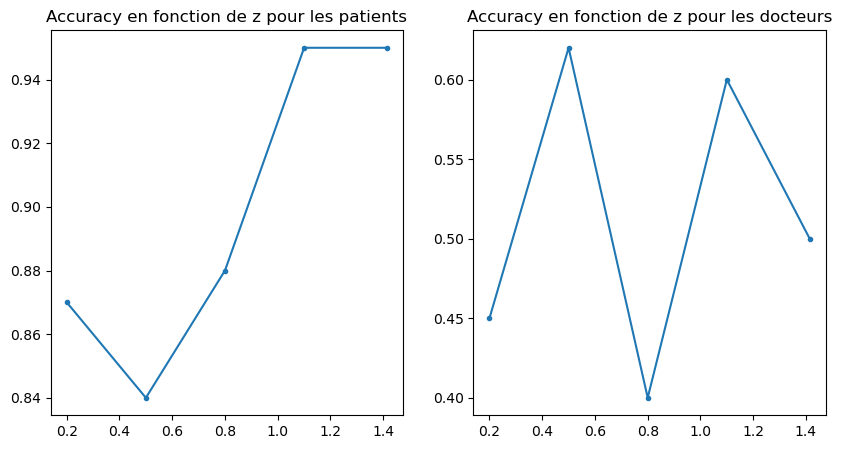

In [96]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot([0.2, 0.5, 0.8, 1.1, np.sqrt(2)], [0.87, 0.84, 0.88, 0.95, 0.95], marker= '.')
ax1.title.set_text('Accuracy en fonction de z pour les patients')
ax2.plot([0.2, 0.5, 0.8, 1.1, np.sqrt(2)], [0.45, 0.62 , 0.4, 0.6, 0.5], marker= '.')
ax2.title.set_text('Accuracy en fonction de z pour les docteurs')

In [16]:
%%capture
res1= aggreg_rmse(100, dist=0.4)

In [17]:
%%capture
res2= aggreg_rmse(100, dist=0.6)

In [18]:
%%capture
res3= aggreg_rmse(100, dist=0.8)

In [19]:
%%capture
res4= aggreg_rmse(100, dist=1)

In [20]:
%%capture
res5= aggreg_rmse(100, dist=1.2)

In [47]:
%%capture
res6= aggreg_rmse(30, dist=np.sqrt(2))

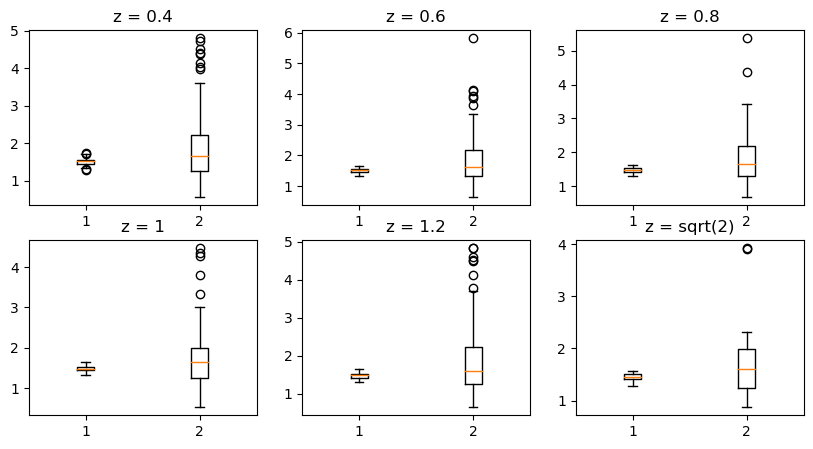

In [57]:
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes[0][0].boxplot(res1)
axes[0][0].title.set_text("z = 0.4")
axes[0][1].boxplot(res2)
axes[0][1].title.set_text("z = 0.6")
axes[0][2].boxplot(res3)
axes[0][2].title.set_text("z = 0.8")
axes[1][0].boxplot(res4)
axes[1][0].title.set_text("z = 1")
axes[1][1].boxplot(res5)
axes[1][1].title.set_text("z = 1.2")
axes[1][2].boxplot(res6)
axes[1][2].title.set_text("z = sqrt(2)")

In [78]:
mean_rmse_patient = [np.array(res1[0]).mean(),
             np.array(res2[0]).mean(),
             np.array(res3[0]).mean(),
             np.array(res4[0]).mean(),
             np.array(res5[0]).mean(),
             np.array(res6[0]).mean()]

mean_rmse_docteurs = [np.array(res1[1]).mean(),
                      np.array(res2[1]).mean(),
                      np.array(res3[1]).mean(),
                      np.array(res4[1]).mean(),
                      np.array(res5[1]).mean(),
                      np.array(res6[1]).mean()]

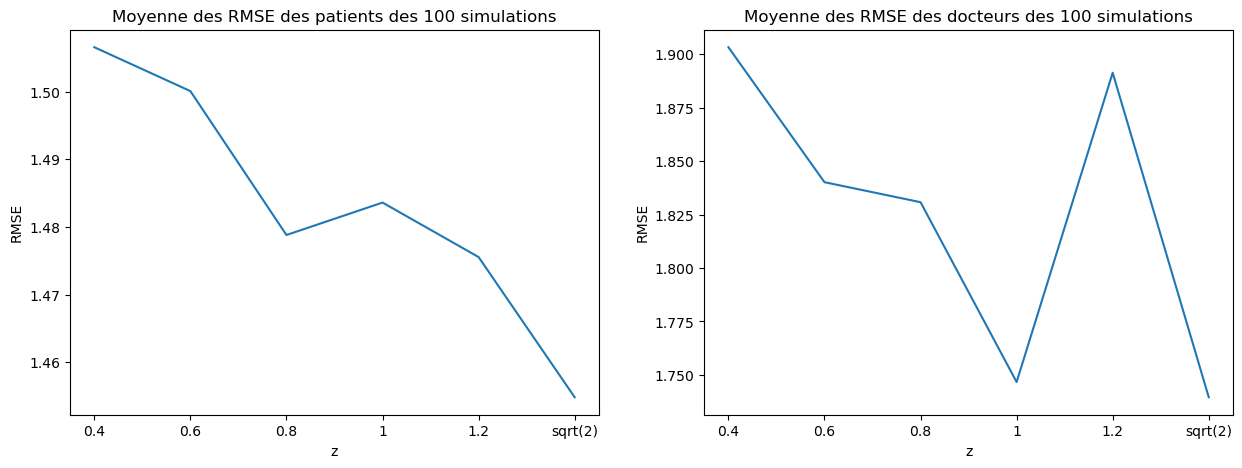

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot([0.4, 0.6, 0.8, 1, 1.2, "sqrt(2)"], mean_rmse_patient)
axes[0].set_xlabel("z")
axes[0].set_ylabel("RMSE")
axes[0].title.set_text("Moyenne des RMSE des patients des 100 simulations")
axes[1].plot([0.4, 0.6, 0.8, 1, 1.2, "sqrt(2)"], mean_rmse_docteurs)
axes[1].set_xlabel("z")
axes[1].set_ylabel("RMSE")
axes[1].title.set_text("Moyenne des RMSE des docteurs des 100 simulations")